In [2]:
pip install torch torchvision torchaudio

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [3]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.0 MB/s eta 0:00:00


In [ ]:
pip install networkx matplotlib

In [ ]:
import os
import copy
import torch
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from torch_geometric.utils import to_networkx
from torch_geometric.data import Data, DataLoader

import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import GATv2Conv

from types import SimpleNamespace

This code is run on Google colab

If running the code on google colab then not need to do any changes or installing of the dataset is not required.


If running in Notebook or IDE
use this link to download the dataset
https://www.kaggle.com/datasets/ellipticco/elliptic-data-set/data, unzip the file and read 3 csv files

In [1]:

classes = pd.read_csv("archive/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edgeslist = pd.read_csv("archive/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
features = pd.read_csv("archive/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header = None)

ModuleNotFoundError: No module named 'torch_geometric'

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import EllipticBitcoinDataset
from torch_geometric.nn import GCNConv, BatchNorm
from torch_geometric.loader import DataLoader

In [9]:
dataset = EllipticBitcoinDataset(root ="/tmp/dataset")

Processing...
Done!


In [10]:
classes = pd.read_csv("/tmp/dataset/raw/elliptic_txs_classes.csv")
edgeslist = pd.read_csv("/tmp/dataset/raw/elliptic_txs_edgelist.csv")
features = pd.read_csv("/tmp/dataset/raw/elliptic_txs_features.csv", header = None)

In [11]:
classes['class'] = classes['class'].map({'unknown': 2, '1': 1, '2': 0})

In [12]:
merge = features.merge(classes, how='left', right_on="txId", left_on=0)
merge = merge.sort_values(0).reset_index(drop=True)

In [13]:
nodes = merge[0].values
map_id = {j:i for i,j in enumerate(nodes)}

# mapping edges to indices
edges = edgeslist.copy()
edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)

edge_index = np.array(edges.values).T
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

# weights for the edges are equal in case of model without attention
weights = torch.tensor([1] * edge_index.shape[1] , dtype=torch.float32)

print("Total amount of edges in DAG:", edge_index.shape)

Total amount of edges in DAG: torch.Size([2, 234355])


In [14]:
node_features = merge.drop(['txId'], axis=1).copy()
node_features[0] = node_features[0].map(map_id)

# store known and unknown nodes
classified_idx = node_features['class'].loc[node_features['class'] != 2].index
unclassified_idx = node_features['class'].loc[node_features['class'] == 2].index

# replace unkown class with 0, to avoid having 3 classes, this data/labels never used in training
node_features['class'] = node_features['class'].replace(2, 0)

labels = node_features['class'].values

# drop indeces, class and temporal axes
node_features = torch.tensor(np.array(node_features.drop([0, 'class', 1], axis=1).values, dtype=np.float32), dtype=torch.float32)

In [15]:
elliptic_dataset = Data(x = node_features,
                        edge_index = edge_index,
                        edge_attr = weights,
                        y = torch.tensor(labels, dtype=torch.float32))
#Printing the count of nodes, edges and features present in the dataset
print(f'Number of nodes: {elliptic_dataset.num_nodes}')
print(f'Number of node features: {elliptic_dataset.num_features}')
print(f'Number of edges: {elliptic_dataset.num_edges}')
print(f'Number of edge features: {elliptic_dataset.num_features}')
print(f'Average node degree: {elliptic_dataset.num_edges / elliptic_dataset.num_nodes:.2f}')
print(f'Number of classes: {len(np.unique(elliptic_dataset.y))}')
print(f'Has isolated nodes: {elliptic_dataset.has_isolated_nodes()}')
print(f'Has self loops: {elliptic_dataset.has_self_loops()}')
print(f'Is directed: {elliptic_dataset.is_directed()}')

Number of nodes: 203769
Number of node features: 165
Number of edges: 234355
Number of edge features: 165
Average node degree: 1.15
Number of classes: 2
Has isolated nodes: False
Has self loops: False
Is directed: True


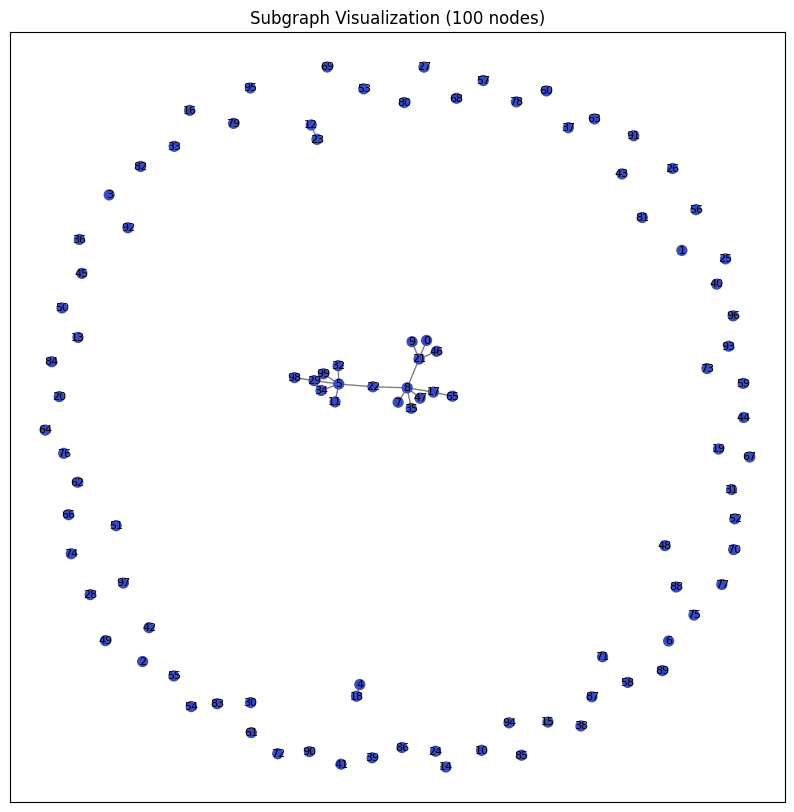

In [16]:
#Plotting sub graph with few nodes
def plot_subgraph(data, num_nodes=100):
    #Converting to NetworkX graph
    G = to_networkx(data, to_undirected=True, node_attrs=['x'])
    sub_nodes = list(G.nodes)[:num_nodes]
    sub_G = G.subgraph(sub_nodes)
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(sub_G, seed=42)
    node_colors = [data.y[i].item() for i in sub_G.nodes]
    nx.draw_networkx_nodes(sub_G, pos, node_color=node_colors, cmap=plt.get_cmap('coolwarm'), node_size=50)
    nx.draw_networkx_edges(sub_G, pos, alpha=0.5)
    labels = {i: i for i in sub_G.nodes}
    nx.draw_networkx_labels(sub_G, pos, labels, font_size=8)

    plt.title(f"Subgraph Visualization ({num_nodes} nodes)")
    plt.show()

plot_subgraph(elliptic_dataset, num_nodes=100)

In [19]:
config = SimpleNamespace(seed = 0,
                         learning_rate = 0.001,
                         weight_decay = 1e-5,
                         input_dim = 165,
                         output_dim = 1,
                         hidden_size = 128,
                         num_epochs = 100,
                         checkpoints_dir = './models/elliptic_gnn',
                         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

print("Using device:", config.device)

Using device: cuda


In [20]:
y_train = labels[classified_idx]

# spliting train set and validation set
_, _, _, _, train_idx, valid_idx = train_test_split(node_features[classified_idx],
                                                    y_train,
                                                    classified_idx,
                                                    test_size=0.15,
                                                    random_state=config.seed,
                                                    stratify=y_train)

elliptic_dataset.train_idx = torch.tensor(train_idx, dtype=torch.long)
elliptic_dataset.val_idx = torch.tensor(valid_idx, dtype=torch.long)
elliptic_dataset.test_idx = torch.tensor(unclassified_idx, dtype=torch.long)

print("Train dataset size:", elliptic_dataset.train_idx.shape[0])
print("Validation dataset size:", elliptic_dataset.val_idx.shape[0])
print("Test dataset size:", elliptic_dataset.test_idx.shape[0])

Train dataset size: 39579
Validation dataset size: 6985
Test dataset size: 157205


In [21]:
class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=4):
        super(GAT, self).__init__()
        self.norm1 = BatchNorm1d(dim_in)
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads,
                              dropout=0.3)
        self.norm2 = BatchNorm1d(dim_h*heads)
        self.fc1 = torch.nn.Linear(dim_h * heads, dim_h)
        self.fc2 = torch.nn.Linear(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.norm1(x)
        h = self.gat1(h, edge_index)
        h = self.norm2(h)
        h = F.leaky_relu(h)
        h = F.relu(self.fc1(h))  # Pass through the first FC layer
        out = self.fc2(h)
        return out

def accuracy(y_pred, y_test, prediction_threshold=0.5):
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()

    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]

    return acc

In [22]:
def train_evaluate(model, data, criterion, optimizer, *args):
    num_epochs = args[0]
    checkpoints_dir = args[1]
    model_filename = args[2]

    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')

    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)
    train_losses = []
    val_losses = []
    model.train()
    for epoch in range(num_epochs+1):
        # Training
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        acc = accuracy(out[data.train_idx], data.y[data.train_idx].unsqueeze(1), prediction_threshold=0.5)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        val_loss = criterion(out[data.val_idx], data.y[data.val_idx].unsqueeze(1))
        val_acc = accuracy(out[data.val_idx], data.y[data.val_idx].unsqueeze(1), prediction_threshold=0.5)
        val_losses.append(val_loss.item())
        if epoch % 10 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.4f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

            if val_loss < best_loss:
                best_loss = val_loss
                print("Saving model for best loss")
                checkpoint = {'state_dict': best_model_wts}
                torch.save(checkpoint, os.path.join(checkpoints_dir, model_filename))
                best_model_wts = copy.deepcopy(model.state_dict())

    return model, train_losses, val_losses

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    preds = ((torch.sigmoid(out) > 0.5).float()*1).squeeze(1)
    return preds

In [24]:
torch.manual_seed(config.seed)

gat_model = GAT(config.input_dim, config.hidden_size, config.output_dim).to(config.device)
data_train = elliptic_dataset.to(config.device)

optimizer = torch.optim.Adam(gat_model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
criterion = torch.nn.BCEWithLogitsLoss()

model, train_losses, val_losses = train_evaluate(gat_model,
               data_train,
               criterion,
               optimizer,
               config.num_epochs,
               config.checkpoints_dir,
               'gat_best_model.pth.tar')

Epoch   0 | Train Loss: 0.634 | Train Acc:  84.42% | Val Loss: 0.6345 | Val Acc: 84.64%
Saving model for best loss
Epoch  10 | Train Loss: 0.236 | Train Acc:  90.24% | Val Loss: 0.2372 | Val Acc: 90.24%
Saving model for best loss
Epoch  20 | Train Loss: 0.195 | Train Acc:  90.24% | Val Loss: 0.1956 | Val Acc: 90.24%
Saving model for best loss
Epoch  30 | Train Loss: 0.176 | Train Acc:  90.24% | Val Loss: 0.1802 | Val Acc: 90.24%
Saving model for best loss
Epoch  40 | Train Loss: 0.163 | Train Acc:  91.14% | Val Loss: 0.1647 | Val Acc: 91.35%
Saving model for best loss
Epoch  50 | Train Loss: 0.150 | Train Acc:  93.94% | Val Loss: 0.1568 | Val Acc: 93.74%
Saving model for best loss
Epoch  60 | Train Loss: 0.138 | Train Acc:  95.27% | Val Loss: 0.1440 | Val Acc: 95.13%
Saving model for best loss
Epoch  70 | Train Loss: 0.123 | Train Acc:  96.15% | Val Loss: 0.1289 | Val Acc: 96.11%
Saving model for best loss
Epoch  80 | Train Loss: 0.109 | Train Acc:  96.66% | Val Loss: 0.1163 | Val Acc:

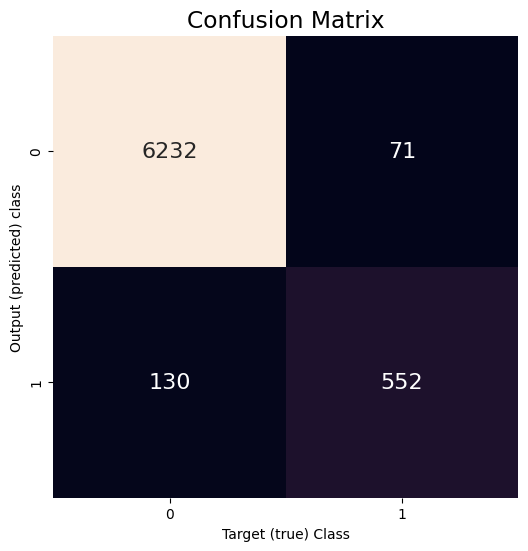

              precision    recall  f1-score   support

       licit       0.98      0.99      0.98      6303
     illicit       0.89      0.81      0.85       682

    accuracy                           0.97      6985
   macro avg       0.93      0.90      0.92      6985
weighted avg       0.97      0.97      0.97      6985



In [25]:
gat_model.load_state_dict(torch.load(os.path.join(config.checkpoints_dir, 'gat_best_model.pth.tar'))['state_dict'])

y_test_preds = test(gat_model, data_train)

# confusion matrix on validation data
conf_mat = confusion_matrix(data_train.y[data_train.val_idx].detach().cpu().numpy(), y_test_preds[valid_idx].cpu())

plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show();

print(classification_report(data_train.y[data_train.val_idx].detach().cpu().numpy(),
                            y_test_preds[valid_idx].cpu(),
                            target_names=['licit', 'illicit']))

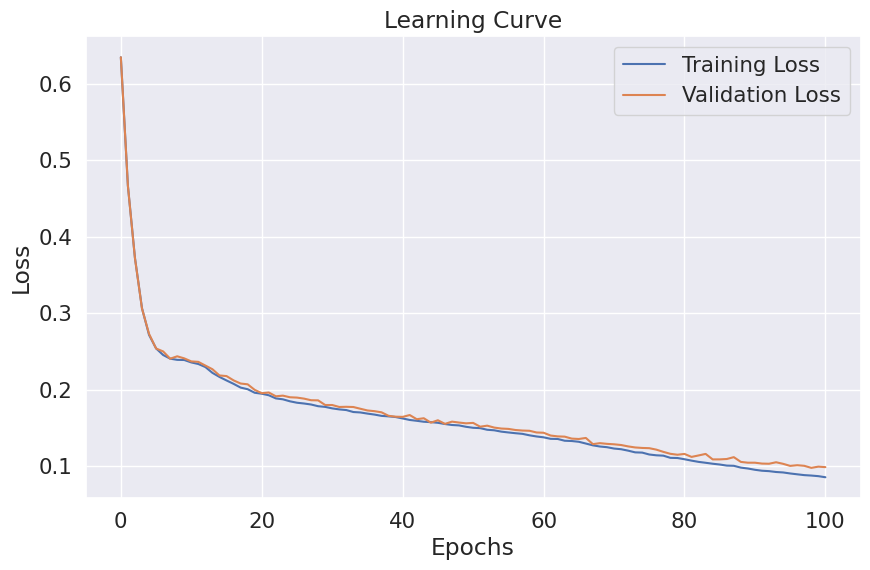

In [26]:
def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curve(train_losses, val_losses)

In [31]:
import torch.nn as nn
class GATWithoutBatchNorm(GAT):
    def __init__(self, dim_in, dim_h, dim_out, heads=4):
        super(GATWithoutBatchNorm, self).__init__(dim_in, dim_h, dim_out, heads)
        self.norm1 = nn.Identity()
        self.norm2 = nn.Identity()
    def forward(self, x, edge_index):
        h = self.gat1(x, edge_index)
        h = F.relu(h)
        h = F.relu(self.fc1(h))
        out = self.fc2(h)
        return out


torch.manual_seed(config.seed)

model2 = GATWithoutBatchNorm(config.input_dim, config.hidden_size, config.output_dim).to(config.device)
data_train = elliptic_dataset.to(config.device)

optimizer = torch.optim.Adam(gat_model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
criterion = torch.nn.BCEWithLogitsLoss()

model, train_losses, val_losses = train_evaluate(model2,
               data_train,
               criterion,
               optimizer,
               config.num_epochs,
               config.checkpoints_dir,
               'gat_best_model.pth.tar')

Epoch   0 | Train Loss: 0.639 | Train Acc:  84.70% | Val Loss: 0.6383 | Val Acc: 84.65%
Saving model for best loss
Epoch  10 | Train Loss: 0.638 | Train Acc:  84.89% | Val Loss: 0.6386 | Val Acc: 84.45%
Epoch  20 | Train Loss: 0.639 | Train Acc:  84.63% | Val Loss: 0.6379 | Val Acc: 84.71%
Saving model for best loss
Epoch  30 | Train Loss: 0.638 | Train Acc:  84.65% | Val Loss: 0.6392 | Val Acc: 84.47%
Epoch  40 | Train Loss: 0.638 | Train Acc:  84.64% | Val Loss: 0.6396 | Val Acc: 84.62%
Epoch  50 | Train Loss: 0.639 | Train Acc:  84.44% | Val Loss: 0.6401 | Val Acc: 84.31%
Epoch  60 | Train Loss: 0.638 | Train Acc:  84.86% | Val Loss: 0.6375 | Val Acc: 84.82%
Saving model for best loss
Epoch  70 | Train Loss: 0.639 | Train Acc:  84.59% | Val Loss: 0.6385 | Val Acc: 84.87%
Epoch  80 | Train Loss: 0.639 | Train Acc:  84.69% | Val Loss: 0.6390 | Val Acc: 84.57%
Epoch  90 | Train Loss: 0.638 | Train Acc:  84.72% | Val Loss: 0.6378 | Val Acc: 84.44%
Epoch 100 | Train Loss: 0.638 | Train A

In [ ]:

class GCN(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                dropout, mode='sup', return_embeds=False):
      super(GCN, self).__init__()

      # A list of GCNConv layers
      self.convs = None

      # A list of 1D batch normalization layers
      self.bns = None

      self.convs = torch.nn.ModuleList([GCNConv(in_channels=input_dim, out_channels=hidden_dim)])
      self.bns = torch.nn.ModuleList()
      for _ in range(num_layers-2):
        self.convs.append(GCNConv(in_channels=hidden_dim, out_channels=hidden_dim))
        self.bns.append(torch.nn.BatchNorm1d(hidden_dim))
      self.bns.append(torch.nn.BatchNorm1d(hidden_dim))
      self.convs.append(GCNConv(in_channels=hidden_dim, out_channels=output_dim))
      self.softmax = torch.nn.LogSoftmax()
      self.mode = mode
      # Probability of an element getting zeroed
      self.dropout = dropout

  def reset_parameters(self):
      for conv in self.convs:
          conv.reset_parameters()
      for bn in self.bns:
          bn.reset_parameters()

  def forward(self, x, adj_t):
      out = x
      for i in range(len(self.bns)):
          out = self.convs[i](out, adj_t)
          out = self.bns[i](out)
          out = F.relu(out)
          out = F.dropout(out, p=self.dropout, training=self.training)
      out = self.convs[-1](out, adj_t)
      if self.mode == 'sup':
          out = self.softmax(out)
      return out

  # Add a method to switch to classification mode
  def switch_to_classification(self, output_dim):
      self.mode = 'sup'
      self.convs[-1] = GCNConv(in_channels=self.convs[-1].in_channels, out_channels=output_dim)

In [29]:
torch.manual_seed(config.seed)

model1 = GCN(input_dim = config.input_dim, hidden_dim = config.hidden_size, output_dim = config.output_dim,num_layers = 5, dropout = 0.4 ).to(config.device)
data_train = elliptic_dataset.to(config.device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([0.08, 0.92]))
model, train_losses, val_losses = train_evaluate(model1,
               data_train,
               criterion,
               optimizer,
               config.num_epochs,
               config.checkpoints_dir,
               'gat_best_model.pth.tar')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch   0 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Saving model for best loss
Epoch  10 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Epoch  20 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Epoch  30 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Epoch  40 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Epoch  50 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Epoch  60 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Epoch  70 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Epoch  80 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Epoch  90 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Epoch 100 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%


In [36]:
from torch_geometric.nn import SAGEConv
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, mode='sup', return_embeds=False):
        super(GraphSAGE, self).__init__()
        # A list of SAGEConv layers
        self.convs = torch.nn.ModuleList()
        # Initialize the first layer
        self.convs.append(SAGEConv(in_channels=input_dim, out_channels=hidden_dim))
        # Append hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(in_channels=hidden_dim, out_channels=hidden_dim))
        # Output layer
        self.convs.append(SAGEConv(in_channels=hidden_dim, out_channels=output_dim))
        self.mode = mode
        self.dropout = dropout
    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index):
        out = x
        for conv in self.convs[:-1]:
            out = conv(out, edge_index)
            out = F.relu(out)
            out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.convs[-1](out, edge_index)
        if self.mode == 'sup':
            out = F.log_softmax(out, dim=1)
        return out

    def switch_to_classification(self, output_dim):
        self.mode = 'sup'
        self.convs[-1] = SAGEConv(in_channels=self.convs[-1].in_channels, out_channels=output_dim)


In [38]:
torch.manual_seed(config.seed)

model3 = GraphSAGE(input_dim = config.input_dim, hidden_dim = config.hidden_size, output_dim = config.output_dim,num_layers = 5, dropout = 0.3 ).to(config.device)
data_train = elliptic_dataset.to(config.device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([0.08, 0.92]))
model, train_losses, val_losses = train_evaluate(model3,
               data_train,
               criterion,
               optimizer,
               config.num_epochs,
               config.checkpoints_dir,
               'gat_best_model.pth.tar')

Epoch   0 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Saving model for best loss
Epoch  10 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Epoch  20 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Epoch  30 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Epoch  40 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Epoch  50 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Epoch  60 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Epoch  70 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Epoch  80 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Epoch  90 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
Epoch 100 | Train Loss: 0.693 | Train Acc:  90.24% | Val Loss: 0.6931 | Val Acc: 90.24%
